<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [58]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [59]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-04-10 14:32:36--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K   101KB/s    in 0.2s    

2019-04-10 14:32:37 (101 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [60]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [61]:
df.shape

(346, 10)

### Convert to date time object 

In [62]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [63]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /root/anaconda3

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2018.03.07 |                0         124 KB  anaconda
    conda-4.5.12               |           py37_0         1.0 MB  anaconda
    seaborn-0.9.0              |           py37_0         379 KB  anaconda
    openssl-1.1.1a             |       h7b6447c_0         4.8 MB  anaconda
    certifi-2018.11.29         |           py37_0         146 KB  anaconda
    ------------------------------------------------------------
                                           Total:         6.4 MB

The following packages will be UPDATED:

    ca-certificates: 2018.03.07-0      --> 2018.03.07-0      anaconda
    certifi:         2018.11.29-py37_0 --> 2018.11.29-py37_0 anaconda
    conda:           4.5.12-py37_0     

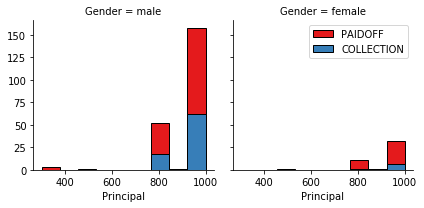

In [64]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

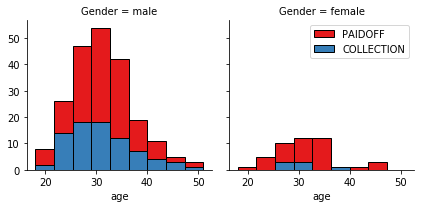

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

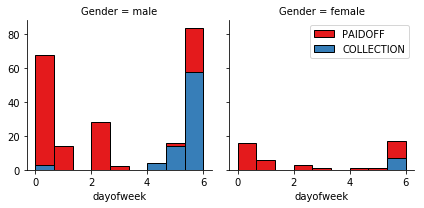

In [65]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [66]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [67]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [68]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [69]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [70]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [71]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [72]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [73]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [74]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/root/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [82]:
from sklearn.neighbors import KNeighborsClassifier
k = 8
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yresultonxtest = neigh.predict(X_test) #orignal test data used to predict some value
from sklearn import metrics                          #y_actual_train_result # y_train_test 
print("KNN  Metric Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train))) # in sample orignal train data of x used to calculate y
print("KNN  Metric Test set Accuracy: ", metrics.accuracy_score(y_test, yresultonxtest))#out of sample
print("KNN  F1 score Train Accuracy: ",f1_score(y_train, neigh.predict(X_train), average='weighted') )
print("KNN F1 score Test Accuracy:",f1_score(y_test,yresultonxtest, average='weighted'))
print("KNN  Jaccard score Train Accuracy: ",jaccard_similarity_score(y_train, neigh.predict(X_train)) )
print("KNN Jaccard score Test Accuracy:",jaccard_similarity_score(y_test,yresultonxtest))

KNN  Metric Train set Accuracy:  0.7971014492753623
KNN  Metric Test set Accuracy:  0.7571428571428571
KNN  F1 score Train Accuracy:  0.7961446461235402
KNN F1 score Test Accuracy: 0.7647772787959703
KNN  Jaccard score Train Accuracy:  0.7971014492753623
KNN Jaccard score Test Accuracy: 0.7571428571428571


# Decision Tree

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [25]:
from sklearn.tree import DecisionTreeClassifier
loan__status = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loan__status.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [41]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
print("DecisionTrees's MetricTrain Accuracy: ", metrics.accuracy_score(y_train, loan__status.predict(X_train)))
print("DecisionTrees's Metric Test Accuracy: ", metrics.accuracy_score(y_test, loan__status.predict(X_test)))
print("DecisionTrees's F1 score Train Accuracy: ",f1_score(y_train, loan__status.predict(X_train), average='weighted') )
print("DecisionTrees's F1 score Test Accuracy:",f1_score(y_test,loan__status.predict(X_test), average='weighted'))
print("DecisionTrees's Jaccard score Train Accuracy: ",jaccard_similarity_score(y_train, loan__status.predict(X_train)) )
print("DecisionTrees's Jaccard score Test Accuracy:",jaccard_similarity_score(y_test,loan__status.predict(X_test)))

DecisionTrees's MetricTrain Accuracy:  0.7463768115942029
DecisionTrees's Metric Test Accuracy:  0.7857142857142857
DecisionTrees's F1 score Train Accuracy:  0.6415811191626409
DecisionTrees's F1 score Test Accuracy: 0.6914285714285714
DecisionTrees's Jaccard score Train Accuracy:  0.7463768115942029
DecisionTrees's Jaccard score Test Accuracy: 0.7857142857142857


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Support Vector Machine

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [28]:
from sklearn import svm
Loan__status = svm.SVC(kernel='rbf')
Loan__status.fit(X_train, y_train) 

/root/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [44]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
print("SVM Metric Train Accuracy: ", metrics.accuracy_score(y_train, Loan__status.predict(X_train)))
print("SVM Metric Test Accuracy: ", metrics.accuracy_score(y_test, Loan__status.predict(X_test)))
print("SVM F1 score Train Accuracy: ",f1_score(y_train, Loan__status.predict(X_train), average='weighted') )
print("SVM F1 score Test Accuracy:",f1_score(y_test,Loan__status.predict(X_test), average='weighted'))
print("SVM Jaccard score Train Accuracy: ",jaccard_similarity_score(y_train, Loan__status.predict(X_train)) )
print("SVM Jaccard score Test Accuracy:",jaccard_similarity_score(y_test,Loan__status.predict(X_test)))



SVM Metric Train Accuracy:  0.782608695652174
SVM Metric Test Accuracy:  0.7428571428571429
SVM F1 score Train Accuracy:  0.7682165861513688
SVM F1 score Test Accuracy: 0.7275882012724117
SVM Jaccard score Train Accuracy:  0.782608695652174
SVM Jaccard score Test Accuracy: 0.7428571428571429


# Logistic Regression

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

In [49]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
print("logistic Regression Metric Train Accuracy: ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("logistic Regression Metric Test Accuracy: ", metrics.accuracy_score(y_test, LR.predict(X_test)))
print("logistic Regression F1 score Train Accuracy: ",f1_score(y_train, LR.predict(X_train), average='weighted') )
print("logistic Regression F1 score Test Accuracy:",f1_score(y_test,LR.predict(X_test), average='weighted'))
print("logistic Regression Jaccard score Train Accuracy: ",jaccard_similarity_score(y_train, LR.predict(X_train)) )
print("logistic Regression Jaccard score Test Accuracy:",jaccard_similarity_score(y_test,LR.predict(X_test)))
print("logistic Regression log_loss Train Accuracy: ",log_loss(y_train, LR.predict_proba(X_train)) )
print("logistic Regression log_loss Test Accuracy:",log_loss(y_test,LR.predict_proba(X_test)))


logistic Regression Metric Train Accuracy:  0.7572463768115942
logistic Regression Metric Test Accuracy:  0.6857142857142857
logistic Regression F1 score Train Accuracy:  0.7341146337750953
logistic Regression F1 score Test Accuracy: 0.6670522459996144
logistic Regression Jaccard score Train Accuracy:  0.7572463768115942
logistic Regression Jaccard score Test Accuracy: 0.6857142857142857
logistic Regression log_loss Train Accuracy:  0.5513966315177746
logistic Regression log_loss Test Accuracy: 0.5772287609479653


# Model Evaluation using Test set

In [20]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [79]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-04-10 14:38:51--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2019-04-10 14:38:52 (29.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [85]:
test_df = pd.read_csv('loan_test.csv')
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.columns
x_test_another = Feature_test[['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor','High School or Below', 'college']].values 
y_test_another = test_df['loan_status'].values
x_test_another = Feature_test
#X[0:20]
x_test_another = preprocessing.StandardScaler().fit(x_test_another).transform(x_test_another.astype(float))
#X[0:10]


/root/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


# KNN

In [93]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

print("KNN  Metric Test set Accuracy: ", metrics.accuracy_score(y_test_another, neigh.predict(x_test_another)))#out of sample

print("KNN F1 score Test Accuracy:",f1_score(y_test_another,neigh.predict(x_test_another), average='weighted'))
knnf1=f1_score(y_test_another,neigh.predict(x_test_another), average='weighted')
print("KNN Jaccard score Test Accuracy:",jaccard_similarity_score(y_test_another,neigh.predict(x_test_another)))
knnjaccard=jaccard_similarity_score(y_test_another,neigh.predict(x_test_another))

KNN  Metric Test set Accuracy:  0.7037037037037037
KNN F1 score Test Accuracy: 0.7037037037037038
KNN Jaccard score Test Accuracy: 0.7037037037037037


# Decision Trees

In [94]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

print("DecisionTrees's Metric Test Accuracy: ", metrics.accuracy_score(y_test_another, loan__status.predict(x_test_another)))

print("DecisionTrees's F1 score Test Accuracy:",f1_score(y_test_another,loan__status.predict(x_test_another), average='weighted'))
desTreef1=f1_score(y_test_another,loan__status.predict(x_test_another), average='weighted')
print("DecisionTrees's Jaccard score Test Accuracy:",jaccard_similarity_score(y_test_another,loan__status.predict(x_test_another)))
Dtreejaccard=jaccard_similarity_score(y_test_another,loan__status.predict(x_test_another))

DecisionTrees's Metric Test Accuracy:  0.7592592592592593
DecisionTrees's F1 score Test Accuracy: 0.6717642373556352
DecisionTrees's Jaccard score Test Accuracy: 0.7592592592592593


# SVM

In [95]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

print("SVM Metric Test Accuracy: ", metrics.accuracy_score(y_test_another, Loan__status.predict(x_test_another)))

print("SVM F1 score Test Accuracy:",f1_score(y_test_another,Loan__status.predict(x_test_another), average='weighted'))
svmf1=f1_score(y_test_another,Loan__status.predict(x_test_another), average='weighted')
print("SVM Jaccard score Test Accuracy:",jaccard_similarity_score(y_test_another,Loan__status.predict(x_test_another)))
svmjaccard=jaccard_similarity_score(y_test_another,Loan__status.predict(x_test_another))

SVM Metric Test Accuracy:  0.7962962962962963
SVM F1 score Test Accuracy: 0.7583503077293734
SVM Jaccard score Test Accuracy: 0.7962962962962963


# Logistic Regression


In [99]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss

print("logistic Regression Metric Test Accuracy: ", metrics.accuracy_score(y_test_another, LR.predict(x_test_another)))

print("logistic Regression F1 score Test Accuracy:",f1_score(y_test_another,LR.predict(x_test_another), average='weighted'))
LogRegf1=f1_score(y_test_another,LR.predict(x_test_another), average='weighted')
print("logistic Regression Jaccard score Test Accuracy:",jaccard_similarity_score(y_test_another,LR.predict(x_test_another)))
logregjaccard=jaccard_similarity_score(y_test_another,LR.predict(x_test_another))
print("logistic Regression log_loss Test Accuracy:",log_loss(y_test_another,LR.predict_proba(x_test_another)))
logreg_logloss=log_loss(y_test_another,LR.predict_proba(x_test_another))

logistic Regression Metric Test Accuracy:  0.7407407407407407
logistic Regression F1 score Test Accuracy: 0.6604267310789049
logistic Regression Jaccard score Test Accuracy: 0.7407407407407407
logistic Regression log_loss Test Accuracy: 0.567215337991298


In [100]:

results = pd.DataFrame({
    'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'],
    'Jaccard': [knnjaccard, Dtreejaccard, svmjaccard, logregjaccard],
    'F1-score': [knnf1, desTreef1, svmf1, LogRegf1],
    'LogLoss': ['NA', 'NA', 'NA', logreg_logloss]
     })
result_df = results.sort_values(by='F1-score', ascending=False)

result_df.head()


,Algorithm,Jaccard,F1-score,LogLoss
2,SVM,0.796296,0.758350,NA
0,KNN,0.703704,0.703704,NA
1,Decision Tree,0.759259,0.671764,NA
3,Logistic Regression,0.740741,0.660427,0.567215


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>